In [14]:
# We want to make a GP that predicts temperature with social variables
import numpy as np
import os
import requests
import scipy.io
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt

mld = os.path.join("C:\\Users\\theod\\Desktop\\UCL\\Machine Learn\\Project\\socio_climate_model\\external_data")

1800.0 2014.0
9.855


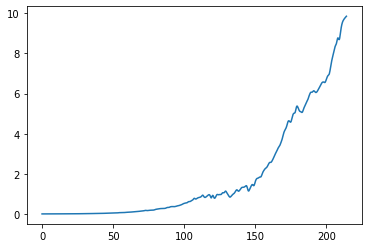

In [15]:
data = np.genfromtxt(os.path.join(mld, "cdiac_fossilfuel.csv"), delimiter=",")
carbon_func = interp1d(data[2:, 0]-1800, data[2:, 1]*10**(-3), kind="cubic")
print(min(data[51:, 0]), max(data[51:, 0]))

t = np.linspace(0, 214, 1000)
plt.plot(t, carbon_func(t))
epsilon2014 = carbon_func(214)
print(epsilon2014)

In [84]:
# constants
Cat0 = (590, 569, 602)          # GtC initial CO2 in atmosphere
Coc0 = (1.4e5, 1.5e5, 1.6e5)          # GtC initial CO2 in ocean reservoir
Cveg0 = (540, 550, 560)         # GtC initial CO2 in vegetation reservoir
Cso0 = (1480, 1500, 1520)       # GtC initial CO2 in soil reservoir
T0 = (288, 288.15, 288.3)       # K initial average atmospheric temperature
kp = (0.175, 0.184, 0.193)      # yr-1 photosynthesis rate constant
kMM = 1.478                     # photosynthesis normalising constant
kc = (26* 1e-6, 29* 1e-6, 32* 1e-6)         # half-saturation point for photosynthesi
KM = (108* 1e-6, 120* 1e-6, 132* 1e-6)      # photosynthesis compensation point
ka = 1.773 * 1e20              # mole volume of atmosphere 
kr = (0.0828, 0.092, 0.1012)    # yr-1 plant respiration constant
kA = 8.7039 * 1e9               # plant respiration normalising constant 
Ea = (54.63e3, 54.83e3, 55.03e3)      # J mol−1 plant respiration activation energy
ksr =  (0.0303, 0.0337, 0.0371)   # yr−1 soil respiration rate constant
kB = 157.072                    #soil respiration normalising constant  
kt = (0.0828, 0.092, 0.1012)    # yr−1 turnover rate constant  
c = (4.22* 1e23, 4.69* 1e23, 5.16* 1e23)    # JK−1 specific heat capacity of Earth’s surface
aE = 5.101 *1e14                #  m2 Earth’s surface area
sigma = 5.67 * 1e-8             # Wm−2 K−4 Stefan-Boltzman constant
L_ = 43655                      #  mol−1 latent heat per mole of water  
R = 8.314                       # J mol−1 K molar gas constant
H = 0.5915                      # relative humidity  
A = (0.203, 0.225, 0.248)       # yr−1 surface albedo
S = (1231, 1368, 1504)          # Wm−2 solar flux 
tauCH4= (0.0208, 0.0231, 0.0254)# methane opacity 
P0  = (1.26* 1e11, 1.4* 1e11, 1.54* 1e11)   # Pa water vapor saturation constant  
F0 = (2.25* 1e-2, 2.5* 1e-2, 2.75* 1e-2)    # yr−1  ocean flux rate constant  
chi = (0.2, 0.3, 0.4)           # characteristic CO2 solubility 
zeta = (40, 50, 60)             # evasion factor
kappa = (0.02, 0.05, 0.2)       # yr−1 social learning rate 
beta = (0.5, 1, 1.5)            # net cost of mitigation 
delta = (0.5, 1, 1.5)           # strength of social norms
fmax  = (4,5,6)                 # maximum of warming cost function f(T) 
omega = (1, 3, 5)               # K nonlinearity of warming cost function f(T)  
Tc = (2.4, 2.5, 2.6)            # K critical temperature of f(T)  
tp = 10                         # yr previous years used for temperature projection  
tf = (0, 25, 50)                # yr years ahead for temperature projection
s = (30, 50, 70)                # yr half-saturation time for epsilon(t) from 2014
epsilon_max = (4.2, 7, 9.8)     # GtC yr−1  maximum change in epsilon(t) from 2014
x0 = (0.01, 0.05, 0.1)          # initial proportion of mitigators 
sec_to_year = 365.25*24*3600

In [125]:
def carbon_conc(Cat):
    pCO2a = 8.3259e13 * (Cat + Cat0[1])/ka
    return pCO2a

def carbon_uptake(T, Cat):
    pCO2a = carbon_conc(Cat)
    if pCO2a >= kc[1] and -15 <= T and T <= 25:
        P = kp[1] * Cveg0[1] * kMM *(pCO2a - kc[1])/(KM[1]+pCO2a-kc[1])* ((15+T)**2) *(25-T) / (5625)
        return P
    else:
        return 0

def rso(T, Cso):
    Rso = ksr[1] * (Cso+Cso0[1]) * kB * np.exp(-308.56/(T+T0[1]-227.13))

    return Rso

def rveg(T, Cveg):
    Rveg = kr[1] * (Cveg+Cveg0[1]) * kA * np.exp(-Ea[1]/(R*(T+T0[1])))

    return Rveg

def turnover(Cveg):
    L = kt[1] * (Cveg+Cveg0[1])
    return L


def ocean_flux(Cat, Coc):
    Foc = F0[1]*chi[1]*(Cat-zeta[1]*Cat0[1]*Coc/Coc0[1])
    return Foc

def atmosphere_dyna(T, Cat):
    pCO2a = carbon_conc(Cat)
    tauCO2 = 1.73 * (pCO2a)**0.263
    tauH2O = 0.0126*(H*P0[1]*np.exp(-L_/(R*(T+T0[1]))))**0.503
    
    Fd = (1-A[1])*S[1]/4 *(1+0.75*(tauCO2+tauH2O+tauCH4[1]))
    return Fd

def fla(Cat, Cveg, Cso, T):
    return carbon_uptake(T, Cat) - rveg(T, Cveg) - rso(T, Cso)

def f(T, t):
    Tlist.append(T)
    if t>=214:
        T += tf[1]/tp * (T - Tlist[int(t*10)-tp])  
    return fmax[1]/(1+np.exp(-omega[1]*(T-Tc[1])))

def epsilon(t):
    if t>=214:
        e = epsilon2014 + (t-214)*epsilon_max[1]/(t-214+s[1])
    else:
        e = carbon_func(t)
    return e

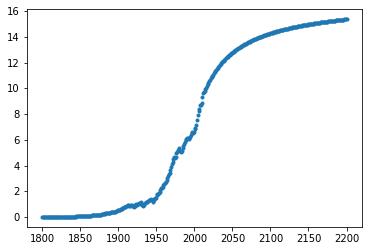

In [154]:
# historical emissions from cdiac
x = np.linspace(0, 400, 400)
y = [epsilon(x[i]) for i in range(x.shape[0])]
plt.plot(x+1800, y, ".");

In [156]:
# system of ODEs
def odes(variables, t):
    x, T, Cat, Coc, Cveg, Cso = variables
    _ = f(T,t)
    
    dx = (kappa[1] * x * (1-x) * (-beta[1] + f(T, t) + delta[1] * (2*x-1)) if t>=214 else 0)
    dCat = epsilon(t) *(1-x) - carbon_uptake(T, Cat) + rveg(T, Cveg) +rso(T, Cso) - ocean_flux(Cat,Coc)
    dCoc = ocean_flux(Cat,Coc)
    dCveg = carbon_uptake(T, Cat) - rveg(T,Cveg) - turnover(Cveg)
    dCso = turnover(Cveg) - rso(T, Cso)
    dT = sec_to_year * (atmosphere_dyna(T,Cat)- sigma * (T+T0[1])**4) * aE/c[1]
    
    return np.array([dx, dT, dCat, dCoc, dCveg, dCso])

In [157]:
# running the simulation
t_sim = 200
Tlist = []
initials = np.array([0.01, 0,0,0,0,0])
t = np.linspace(0, 214+t_sim, (214+t_sim)*10)

solutions = odeint(odes, initials, t, full_output=0)

In [158]:
solutions.shape

(4140, 6)

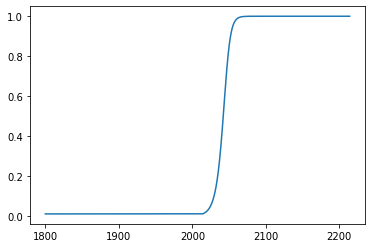

In [159]:
# plot of solutions
plt.plot(t+1800 , solutions[:,0]);

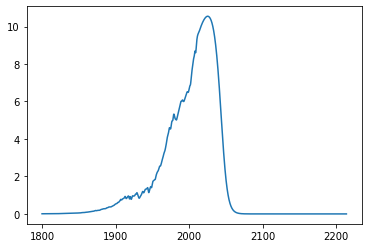

In [163]:
# historical emissions from cdiac
t = np.linspace(0, 214+t_sim, (214+t_sim)*10)
y = [epsilon(t[i])*(1-solutions[i,0]) for i in range(t.shape[0])]
plt.plot(t+1800, y);